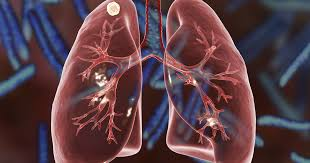

Lung cancer is a type of cancer that starts in the lungs, which are two spongy organs located in the chest that help us breathe. There are two main types of lung cancer: non-small cell lung cancer (NSCLC) and small cell lung cancer (SCLC). NSCLC is the most common type, accounting for around 85% of all lung cancers, while SCLC is a less common but more aggressive type.

Lung cancer can develop when cells in the lungs grow and divide uncontrollably, forming a tumor. These tumors can then spread to other parts of the body, such as the lymph nodes, bones, or brain. Lung cancer is a serious and often deadly disease, with smoking being the leading cause of most cases. Other risk factors include exposure to secondhand smoke, air pollution, radon gas, and asbestos. Symptoms of lung cancer can include coughing, chest pain, shortness of breath, and weight loss.

Early detection and treatment are important for improving the chances of survival, so it's important to speak with a healthcare provider if you have any concerns about lung cancer.

# About the data

folder lung_image_sets contains three secondary subfolders: lung_aca subfolder with 5000 images of lung adenocarcinomas, lung_scc subfolder with 5000 images of lung squamous cell carcinomas, and lung_n subfolder with 5000 images of benign lung tissues.

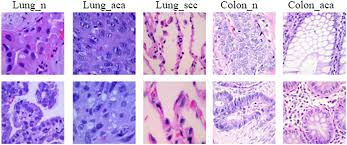

# Importing libraries

In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os                       
import numpy as np 
import h5py
import pandas as pd             
import seaborn as sns
import torch                    
import matplotlib.pyplot as plt 
import torch.nn as nn          
from torch.utils.data import DataLoader  
from PIL import Image          
import torch.nn.functional as F 
import torchvision.transforms as transforms   
from torchvision.utils import make_grid       
from torchvision.datasets import ImageFolder  
from torchsummary import summary              
import tensorflow as ts 
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

2024-03-02 15:59:28.720976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 15:59:28.721143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 15:59:28.921569: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data loading and exploring

In [3]:
lung_dir = "../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
lungs = os.listdir(lung_dir)

In [4]:
lungs

['lung_aca', 'lung_scc', 'lung_n']

In [5]:
# Number of images for each disease
nums_train = {}
nums_val = {}
for lung in lungs:
    nums_train[lung] = len(os.listdir(lung_dir + '/' + lung))
img_per_class_train = pd.DataFrame(nums_train.values(), index=nums_train.keys(), columns=["no. of images"])
print('Train data distribution :')
img_per_class_train

Train data distribution :


no. of images
lung_aca           5000
lung_scc           5000
lung_n             5000

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


<Axes: title={'center': 'data distribution '}, xlabel='Type of lung cancer', ylabel='Number of image'>

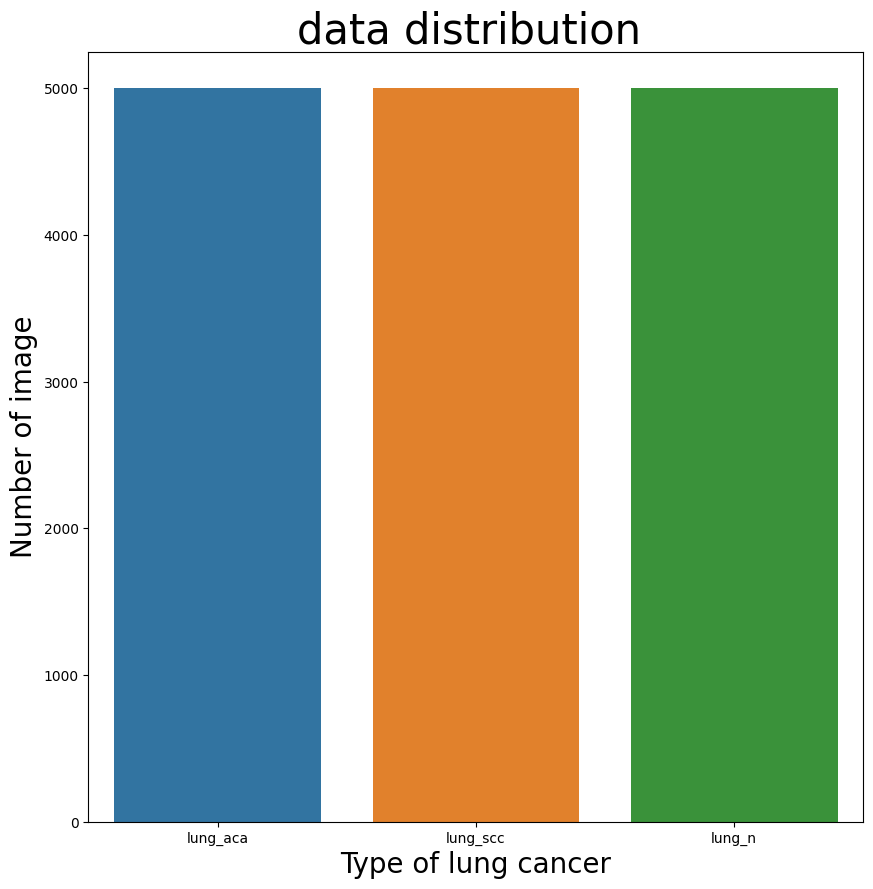

In [6]:
plt.figure(figsize=(10,10))
plt.title('data distribution ',fontsize=30)
plt.ylabel('Number of image',fontsize=20)
plt.xlabel('Type of lung cancer',fontsize=20)

keys = list(nums_train.keys())
vals = list(nums_train.values())
sns.barplot(x=keys, y=vals)

# Show some example for lung cancer

In [7]:
# Function to show image
train = ImageFolder(lung_dir, transform=transforms.ToTensor())
def show_image(image, label):
    print("Label :" + train.classes[label] + "(" + str(label) + ")")
    return image.permute(1, 2, 0)

# Lung_aca

Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)
Label :lung_aca(0)


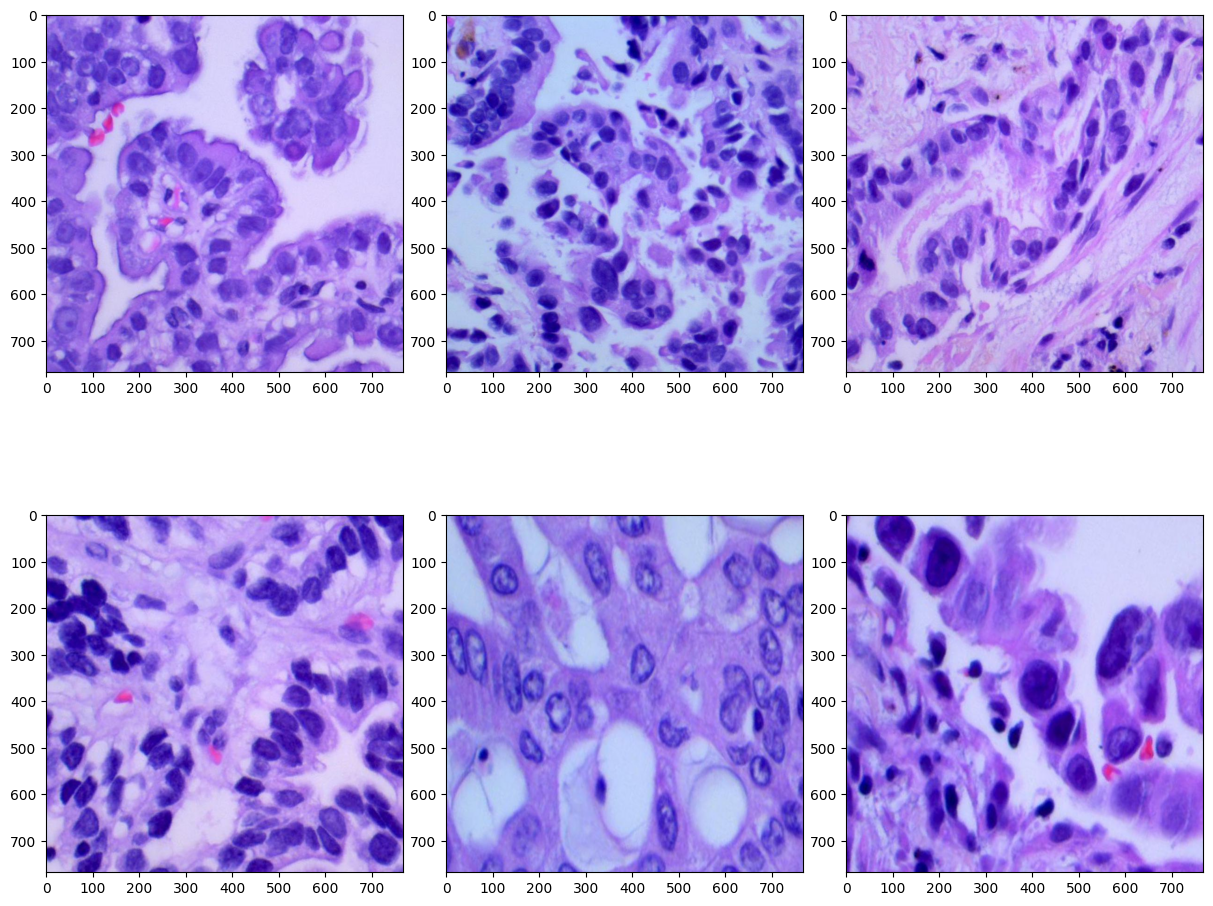

In [8]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[1]))
axs[0,1].imshow(show_image(*train[1100]))
axs[1, 0].imshow(show_image(*train[2010]))
axs[1,1].imshow(show_image(*train[3500]))
axs[0,2].imshow(show_image(*train[4120]))
axs[1,2].imshow(show_image(*train[4860]))

# Lung_n

Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)
Label :lung_n(1)


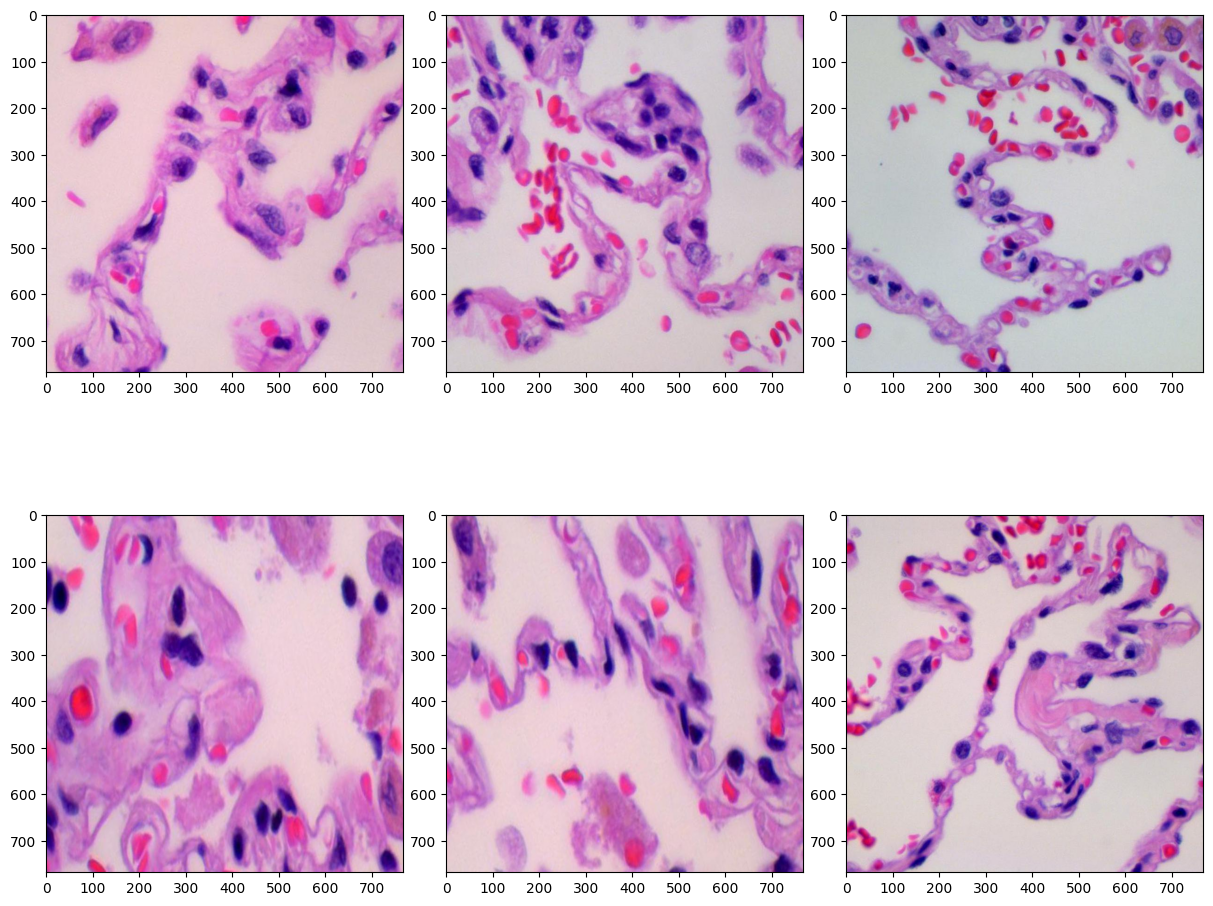

In [9]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[5010]))
axs[0,1].imshow(show_image(*train[6050]))
axs[1, 0].imshow(show_image(*train[7000]))
axs[1,1].imshow(show_image(*train[7500]))
axs[0,2].imshow(show_image(*train[8000]))
axs[1,2].imshow(show_image(*train[8620]))

# Lung_scc

Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)
Label :lung_scc(2)


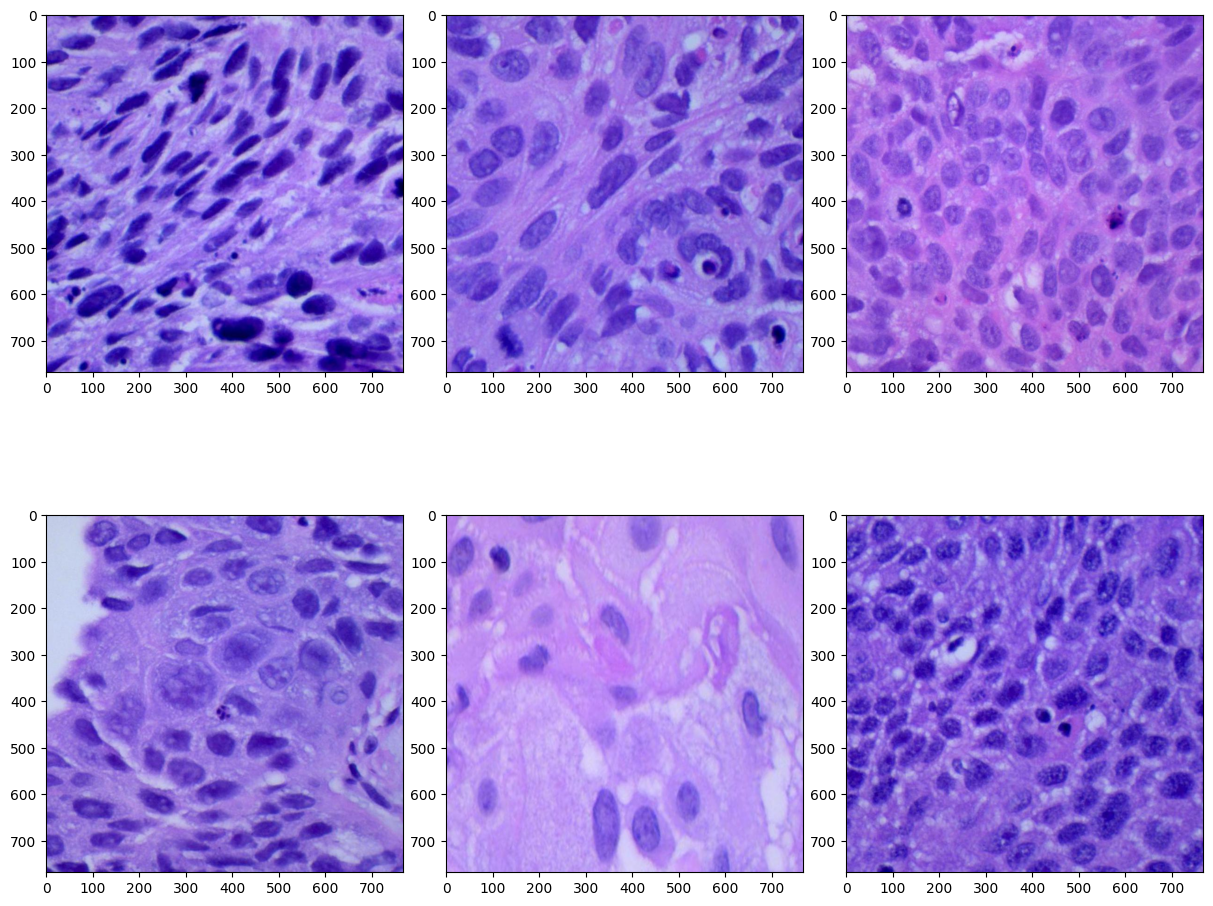

In [10]:
fig, axs = plt.subplots(2, 3,figsize=(12,10))
fig.tight_layout(pad=0)
axs[0,0].imshow(show_image(*train[11001]))
axs[0,1].imshow(show_image(*train[12000]))
axs[1, 0].imshow(show_image(*train[13050]))
axs[1,1].imshow(show_image(*train[14000]))
axs[0,2].imshow(show_image(*train[14200]))
axs[1,2].imshow(show_image(*train[14800]))

# Modeling

In [11]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 20 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.2
                                                         )
valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory(lung_dir, subset='training', target_size=(224,224), batch_size=64, color_mode='rgb', 
                                            class_mode='categorical', shuffle=True)

val_data = valid_gen.flow_from_directory(lung_dir, subset='validation', target_size=(224,224), batch_size=64, color_mode='rgb', 
                                            class_mode='categorical', shuffle=False)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [12]:
test_gen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_data = test_gen.flow_from_directory(
    lung_dir, 
    target_size=(224,224), 
    batch_size=64, 
    color_mode='rgb', 
    class_mode='categorical', 
    shuffle=False
)

Found 15000 images belonging to 3 classes.


In [13]:
class_names = {0: 'Lung benign tissue', 1: 'Lung adenocarcinoma', 2:'Lung squamous cell carcinoma'}

In [14]:
import numpy
unique, counts = numpy.unique(val_data.classes, return_counts=True)

dict(zip(unique, counts))

{0: 1000, 1: 1000, 2: 1000}

In [15]:
print(class_names)

{0: 'Lung benign tissue', 1: 'Lung adenocarcinoma', 2: 'Lung squamous cell carcinoma'}


In [16]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))

model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(64, 3, activation='relu'))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(128, 3, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,443 (84.86 MB)

 Trainable params: 22,245,443 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(train_data,
          validation_data=val_data,
          epochs = 10)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 1098s 6s/step - accuracy: 0.7275 - loss: 1.0952 - val_accuracy: 0.9020 - val_loss: 0.2460
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1075s 6s/step - accuracy: 0.9044 - loss: 0.2299 - val_accuracy: 0.9313 - val_loss: 0.1969
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1096s 6s/step - accuracy: 0.9277 - loss: 0.1855 - val_accuracy: 0.8800 - val_loss: 0.2633
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1078s 6s/step - accuracy: 0.9315 - loss: 0.1749 - val_accuracy: 0.9367 - val_loss: 0.1704
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1062s 6s/step - accuracy: 0.9477 - loss: 0.1320 - val_accuracy: 0.9353 - val_loss: 0.1624
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1111s 6s/step - accuracy: 0.9482 - loss: 0.1266 - val_accuracy: 0.9420 - val_loss: 0.1443
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1110s 6s/step - accuracy: 0.9544 - loss: 0.1085 - val_accuracy: 0.9477 - val_loss: 0.1306
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1108s 6s/step - accuracy: 0.9581 - loss: 0.1032 - val_accurac

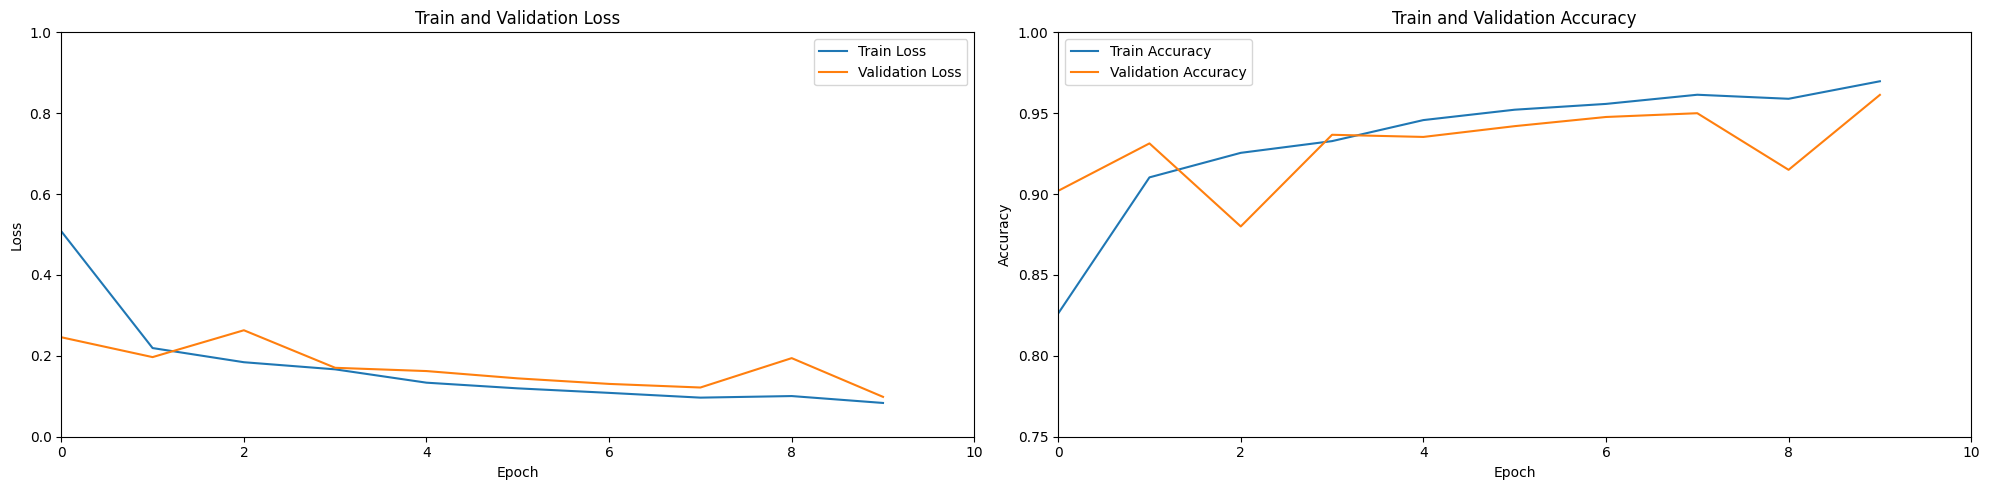

In [18]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)  # Adjusted to 10 epochs
plt.ylim(0.0, 1.0)
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 10)  # Adjusted to 10 epochs
plt.ylim(0.75, 1.0)
plt.legend()
plt.tight_layout()

In [19]:
from sklearn.metrics import classification_report

Y_pred = model.predict(val_data)
y_pred = np.argmax(Y_pred, axis=1)

print(classification_report(val_data.classes, y_pred))

47/47 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1000
           1       1.00      1.00      1.00      1000
           2       0.92      0.96      0.94      1000

    accuracy                           0.96      3000
   macro avg       0.96      0.96      0.96      3000
weighted avg       0.96      0.96      0.96      3000



# Evaluation

In [20]:
loss, accuracy = model.evaluate(train_data)

188/188 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.9657 - loss: 0.0915


In [21]:
accuracy*100

96.5250015258789

In [22]:
val_loss, val_accuracy = model.evaluate(val_data)  
val_accuracy * 100

47/47 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9417 - loss: 0.1544


96.13333344459534

In [23]:
test_loss, test_accuracy = model.evaluate(test_data)
test_accuracy_percentage = test_accuracy * 100
print("Test Accuracy: {:.2f}%".format(test_accuracy_percentage))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.9483 - loss: 0.1421
Test Accuracy: 96.93%


# Prediction

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

First image to predict
Actual label: 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
Predicted label: 0


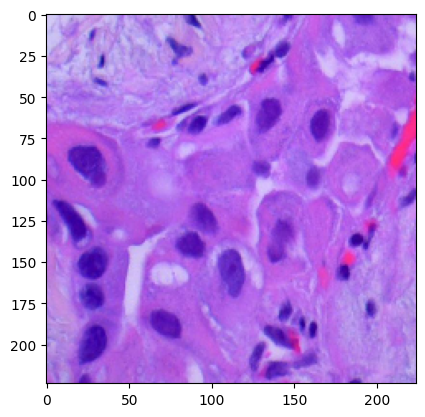

In [25]:
import numpy as np

# Assuming class_names is defined elsewhere in your code
class_names = list(class_names)

for images_batch, labels_batch in test_data:
    first_image = images_batch[0]
    
    # Convert labels_batch[0] to integer
    first_label = np.argmax(labels_batch[0])
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    
    # Predict the label for the batch
    batch_prediction = model.predict(images_batch)
    predicted_label = np.argmax(batch_prediction[0])
    print("Predicted label:", class_names[predicted_label])
    
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


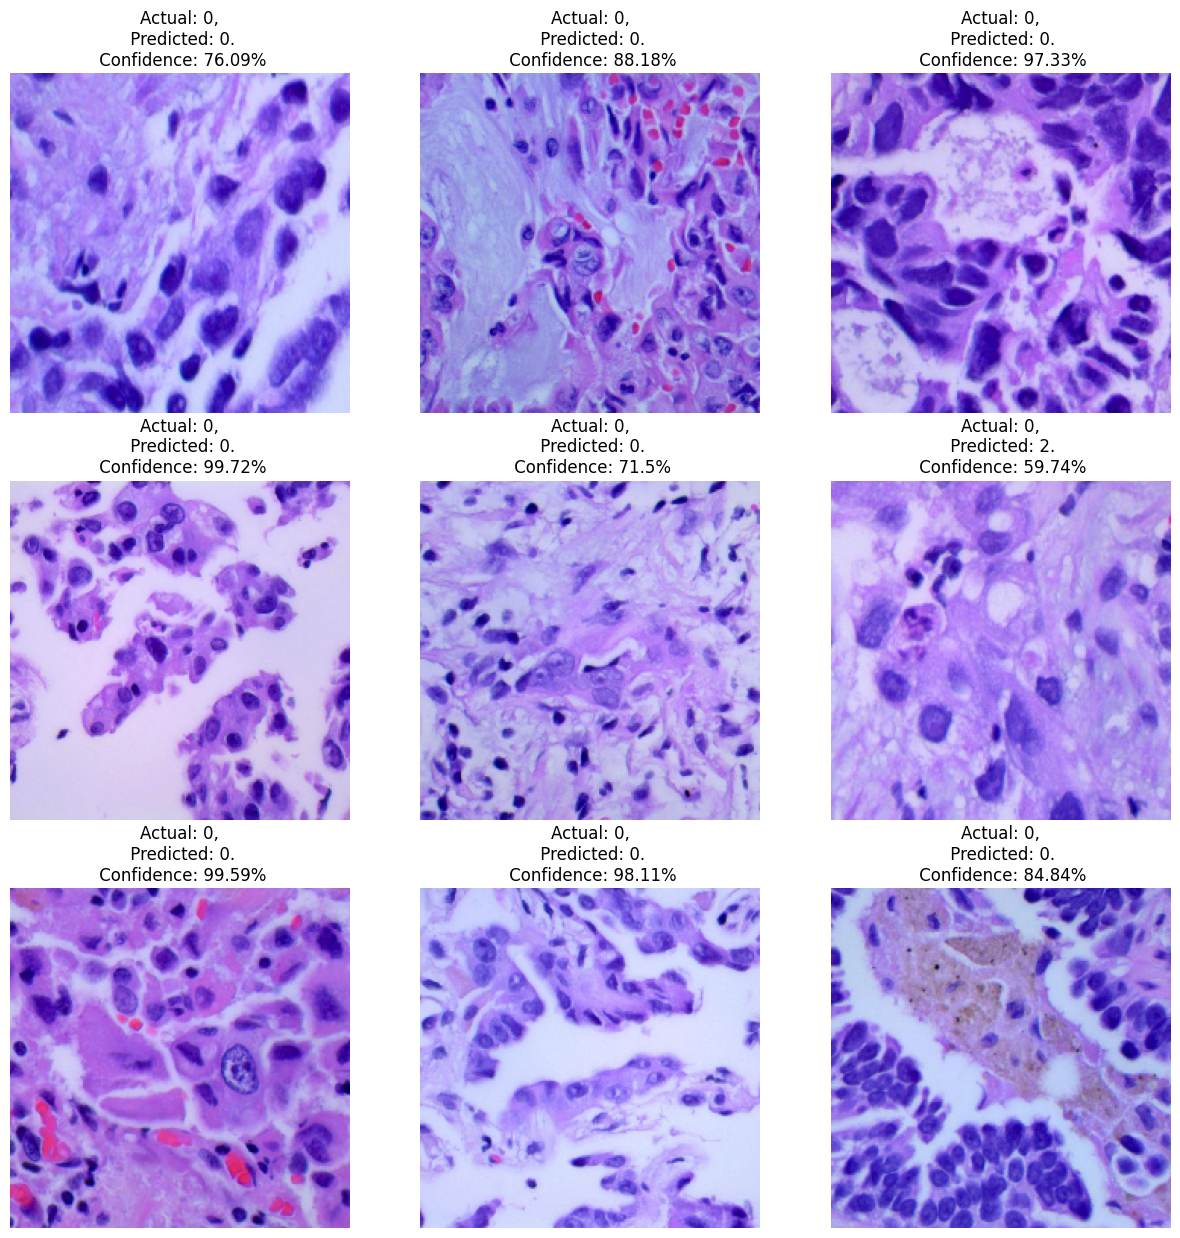

In [26]:
import tensorflow as tf

plt.figure(figsize=(15, 15))
for images, labels in test_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model, images[i])
        
        # Convert labels[i] to integer using np.argmax()
        actual_class = class_names[np.argmax(labels[i])]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

# Convert model to h5

In [27]:
model.save('Lung Cancer.h5')

In [28]:
import tensorflow as tf

new_model = tf.keras.models.load_model('Lung Cancer.h5')
results = new_model.evaluate(val_data)
tf.print('Accuracy: ', results[1]*100)

47/47 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9417 - loss: 0.1544
Accuracy:  96.13333344459534


In [29]:
from PIL import Image
import numpy as np
# Load the test image
test_image_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg"
test_image = Image.open(test_image_path)
# Preprocess the image (resize, normalize, etc.)
# Example:
test_image = test_image.resize((224, 224))  # Resize the image to match the input size
test_image = np.array(test_image) / 255.0   # Normalize pixel values
# Add a batch dimension to the image
test_image = np.expand_dims(test_image, axis=0)
# Make prediction
prediction = new_model.predict(test_image)
# Get the predicted class label
predicted_class = np.argmax(prediction)
# Print the predicted class
print("Predicted Class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Predicted Class: 2


# Confusion Matrix

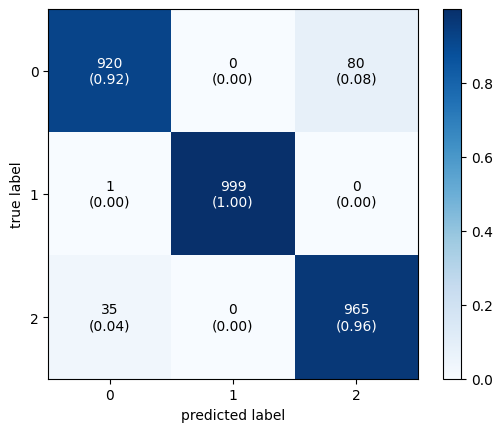

In [30]:
from mlxtend.plotting import plot_confusion_matrix
# calculating and plotting the confusion matrix
cm1 = confusion_matrix(val_data.classes, y_pred)
plot_confusion_matrix(conf_mat=cm1,show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()